In [1]:
!pip install keras
!pip install sklearn
!pip install matplotlib
!pip install -U -q PyDrive

  Running setup.py bdist_wheel for sklearn ... - done
  Stored in directory: /content/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn


In [2]:
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [0]:
from keras import backend as K
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_import = drive.CreateFile({'id':'1p1bsltfTcIrZ_kfE6kwGTPzcdXorHbb2'})
file_import.GetContentFile('colab_setup.py') 
from colab_setup import setup

setup(drive)

In [6]:
!ls

colab_setup.py			 roc_auc_callback.py	X_train.npy
custom_fast_text_embeddings.npy  sample_submission.csv	X_val.npy
datalab				 train_model.py		y_test.npy
fast_text_embeddings.npy	 X_submission.npy	y_train_full.npy
plot_history.py			 X_test.npy		y_train.npy
__pycache__			 X_train_full.npy	y_val.npy


In [0]:
import numpy as np
import os

from plot_history import plot_history
from roc_auc_callback import RocAucCallback
from train_model import train_with_cv, train_with_submitting, evaluate_on_test

from keras.layers import *
from keras.layers.merge import *
from keras.initializers import *
from keras.models import Model

In [0]:
from keras.optimizers import *
from keras.initializers import *
from keras.layers import *
from keras.layers.merge import *
from keras.models import *

residual_convolution_options = dict({
    'dropout_mode': 'spatial',
    'dropout_rate': 0.2,
    'filters': 300,
    'kernel_size': 1,
    'strides': 1,
    'padding': 'same',
    'activation': 'elu',
    'should_preactivate': True
})

def convolution_block(input_layer, options):
    convolution_input = Input(shape=[
        int(input_layer.shape[1]),
        int(input_layer.shape[2])
    ])

    convolution_block = convolution_input

    if(options['should_preactivate']):
        convolution_block = BatchNormalization()(convolution_block)
        convolution_block = Activation(options['activation'])(convolution_block)
        convolution_block = Conv1D(options['filters'], options['kernel_size'], strides=options['strides'],
                                   padding=options['padding'], activation='linear', kernel_initializer='he_normal')(convolution_block)
    else:
        convolution_block = Conv1D(options['filters'], options['kernel_size'], strides=options['strides'],
                                   padding=options['padding'], activation='linear', kernel_initializer='he_normal')(convolution_block)
        convolution_block = BatchNormalization()(convolution_block)
        convolution_block = Activation(options['activation'])(convolution_block)

    convolution_output = convolution_block

    if(options['dropout_mode'] == 'spatial'):
        convolution_output = SpatialDropout1D(options['dropout_rate'])(convolution_output)
    if(options['dropout_mode']== 'vanilla'):
        convolution_output = Dropout(options['dropout_rate'])(convolution_output)

    return Model(inputs=[convolution_input], outputs=[convolution_output])(input_layer)

In [0]:
def residual_add_block(input_layer, should_pool):
    convolution_input = Input(shape=[
        int(input_layer.shape[1]),
        int(input_layer.shape[2])
    ])
    
    residual_block_pool = convolution_input

    if(should_pool):
        residual_block_pool = MaxPooling1D(pool_size=2, strides=2, padding='same')(convolution_input)

    residual_block = add([
        residual_block_pool,
        convolution_block(residual_block_pool, residual_convolution_options)
    ])
    residual_block = add([
        residual_block,
        convolution_block(residual_block, residual_convolution_options)
    ])
    
    convolution_output = add([residual_block, residual_block_pool])

    return Model(inputs=[convolution_input], outputs=[convolution_output])(input_layer)
  
def add_block(input_layer, should_pool):
    convolution_input = Input(shape=[
        int(input_layer.shape[1]),
        int(input_layer.shape[2])
    ])
    
    residual_block_pool = convolution_input

    if(should_pool):
        residual_block_pool = MaxPooling1D(pool_size=2, strides=2, padding='same')(convolution_input)

    residual_block = add([
        residual_block_pool,
        convolution_block(residual_block_pool, residual_convolution_options)
    ])
    residual_block = add([
        residual_block,
        convolution_block(residual_block, residual_convolution_options)
    ])
    
    convolution_output = residual_block
    
    return Model(inputs=[convolution_input], outputs=[convolution_output])(input_layer)

In [0]:
def yoon_kim_feature_extractor(input_layer, filters):
    extractor_block_input = Input(shape=[
        int(input_layer.shape[1]),
        int(input_layer.shape[2])
    ])

    block_1_conv_1 = Conv1D(filters, 1, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm1 = BatchNormalization()(block_1_conv_1)
    block_1_batchnorm1 = ELU()(block_1_batchnorm1)
    block_1_max_pool1 = GlobalMaxPooling1D()(block_1_batchnorm1)

    block_1_conv_2 = Conv1D(filters, 2, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm2 = BatchNormalization()(block_1_conv_2)
    block_1_batchnorm2 = ELU()(block_1_batchnorm2)
    block_1_max_pool2 = GlobalMaxPooling1D()(block_1_batchnorm2)

    block_1_conv_3 = Conv1D(filters, 3, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm3 = BatchNormalization()(block_1_conv_3)
    block_1_batchnorm3 = ELU()(block_1_batchnorm3)
    block_1_max_pool3 = GlobalMaxPooling1D()(block_1_batchnorm3)

    block_1_conv_4 = Conv1D(filters, 5, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm4 = BatchNormalization()(block_1_conv_4)
    block_1_batchnorm4 = ELU()(block_1_batchnorm4)
    block_1_max_pool4 = GlobalMaxPooling1D()(block_1_batchnorm4)

    features = concatenate([
        block_1_max_pool1, 
        block_1_max_pool2, 
        block_1_max_pool3, 
        block_1_max_pool4
    ])
    
    extractor_block_output = Dropout(0.2)(features)
    
    return Model(
        inputs=[extractor_block_input], 
        outputs=[extractor_block_output]
    )(input_layer)

In [0]:
def classification_block(input_layer, dropout_rate = 0.2):
      
    model = Dense(256, activation = 'linear', kernel_initializer = 'he_normal')(input_layer)
    model = BatchNormalization()(model)
    model = ELU()(model)
    model = Dropout(dropout_rate)(model)
    
    model = Dense(256, activation = 'linear', kernel_initializer = 'he_normal')(model)
    model = BatchNormalization()(model)
    model = ELU()(model)
    model = Dropout(dropout_rate)(model)

    classification_block_output = Dense(6, activation='sigmoid', kernel_initializer = 'glorot_normal')(model)
    
    return classification_block_output

In [12]:
max_words= 30000
max_words_length = 400
embedding_dimension = 300

input_layer = Input(shape=(max_words_length,))

pretrained_embedding_layer = Embedding(
    max_words, 
    output_dim=embedding_dimension, 
    input_length=max_words_length,
    weights = [np.load('fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
pretrained_embedding_layer = SpatialDropout1D(0.2)(pretrained_embedding_layer)

custom_embedding_layer = Embedding(
    max_words, 
    output_dim=embedding_dimension, 
    input_length=max_words_length,
    weights = [np.load('custom_fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
custom_embedding_layer = SpatialDropout1D(0.2)(custom_embedding_layer)

averaged_embedding_layer = Average()([pretrained_embedding_layer, custom_embedding_layer])
averaged_embedding_layer = SpatialDropout1D(0.2)(averaged_embedding_layer)

model = add_block(averaged_embedding_layer, should_pool = False)
model = add_block(model, should_pool = True)
model = add_block(model, should_pool = True)
model = add_block(model, should_pool = True)

output_layer = yoon_kim_feature_extractor(model, residual_convolution_options['filters'])
output_layer = classification_block(output_layer)

model = Model(input_layer, output_layer)

model.compile(loss='binary_crossentropy', 
            optimizer='Adam',
            metrics=['accuracy'])          

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 400, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
spatial_dr

In [13]:
history = train_with_cv(model, epochs= 64, batchSize=32, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/64
 21376/102124 [=====>........................] - ETA: 4:49 - loss: 0.1141 - acc: 0.9621

 65600/102124 [==================>...........] - ETA: 2:02 - loss: 0.0824 - acc: 0.9720

102112/102124 [============================>.] - ETA: 0s - loss: 0.0748 - acc: 0.9743

102124/102124 [==============================] - 363s 4ms/step - loss: 0.0748 - acc: 0.9743 - val_loss: 0.0480 - val_acc: 0.9820
Epoch 2/64
 13952/102124 [===>..........................] - ETA: 4:46 - loss: 0.0569 - acc: 0.9790

 66752/102124 [==================>...........] - ETA: 1:54 - loss: 0.0566 - acc: 0.9793

102124/102124 [==============================] - 354s 3ms/step - loss: 0.0557 - acc: 0.9797 - val_loss: 0.0521 - val_acc: 0.9798
roc-auc: 0.9821 - roc-auc_val: 0.9783                                                                                                    
Epoch 3/64
   320/102124 [..............................] - ETA: 5:29 - loss: 0.0615 - acc: 0.9771

 40192/102124 [==========>...................] - ETA: 3:20 - loss: 0.0528 - acc: 0.9803

102112/102124 [============================>.] - ETA: 0s - loss: 0.0520 - acc: 0.9807

102124/102124 [==============================] - 354s 3ms/step - loss: 0.0520 - acc: 0.9807 - val_loss: 0.0452 - val_acc: 0.9829
Epoch 4/64
 13856/102124 [===>..........................] - ETA: 4:45 - loss: 0.0511 - acc: 0.9809

 77824/102124 [=====================>........] - ETA: 1:18 - loss: 0.0496 - acc: 0.9815

102124/102124 [==============================] - 354s 3ms/step - loss: 0.0493 - acc: 0.9816 - val_loss: 0.0459 - val_acc: 0.9821
roc-auc: 0.9863 - roc-auc_val: 0.9829                                                                                                    
Epoch 5/64
  2976/102124 [..............................] - ETA: 5:20 - loss: 0.0513 - acc: 0.9807

 43840/102124 [===========>..................] - ETA: 3:08 - loss: 0.0468 - acc: 0.9825

 81248/102124 [======================>.......] - ETA: 1:07 - loss: 0.0477 - acc: 0.9819

102124/102124 [==============================] - 354s 3ms/step - loss: 0.0478 - acc: 0.9819 - val_loss: 0.0445 - val_acc: 0.9827
Epoch 6/64
  5920/102124 [>.............................] - ETA: 5:07 - loss: 0.0444 - acc: 0.9832

 41760/102124 [===========>..................] - ETA: 3:13 - loss: 0.0459 - acc: 0.9825

 78112/102124 [=====================>........] - ETA: 1:17 - loss: 0.0462 - acc: 0.9824

102124/102124 [==============================] - 352s 3ms/step - loss: 0.0465 - acc: 0.9823 - val_loss: 0.0436 - val_acc: 0.9829
roc-auc: 0.9885 - roc-auc_val: 0.9852                                                                                                    
Epoch 7/64
  2976/102124 [..............................] - ETA: 5:22 - loss: 0.0445 - acc: 0.9840

 42144/102124 [===========>..................] - ETA: 3:14 - loss: 0.0440 - acc: 0.9833

 91648/102124 [=========================>....] - ETA: 33s - loss: 0.0449 - acc: 0.9829

102124/102124 [==============================] - 355s 3ms/step - loss: 0.0450 - acc: 0.9828 - val_loss: 0.0426 - val_acc: 0.9831
Epoch 8/64
 10080/102124 [=>............................] - ETA: 4:58 - loss: 0.0421 - acc: 0.9835

 53376/102124 [==============>...............] - ETA: 2:37 - loss: 0.0442 - acc: 0.9828

 90464/102124 [=========================>....] - ETA: 37s - loss: 0.0443 - acc: 0.9828

102124/102124 [==============================] - 354s 3ms/step - loss: 0.0442 - acc: 0.9828 - val_loss: 0.0422 - val_acc: 0.9835
roc-auc: 0.9903 - roc-auc_val: 0.9873                                                                                                    
Epoch 9/64
  5984/102124 [>.............................] - ETA: 5:11 - loss: 0.0414 - acc: 0.9834

 50848/102124 [=============>................] - ETA: 2:46 - loss: 0.0431 - acc: 0.9834

 88992/102124 [=========================>....] - ETA: 42s - loss: 0.0433 - acc: 0.9833

102124/102124 [==============================] - 354s 3ms/step - loss: 0.0432 - acc: 0.9834 - val_loss: 0.0424 - val_acc: 0.9834
Epoch 10/64
  8864/102124 [=>............................] - ETA: 5:00 - loss: 0.0418 - acc: 0.9836

 61120/102124 [================>.............] - ETA: 2:11 - loss: 0.0419 - acc: 0.9838

 97728/102124 [===========================>..] - ETA: 14s - loss: 0.0425 - acc: 0.9835

102124/102124 [==============================] - 351s 3ms/step - loss: 0.0426 - acc: 0.9835 - val_loss: 0.0484 - val_acc: 0.9806

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.00019614602206274867.
roc-auc: 0.9913 - roc-auc_val: 0.9876                                                                                                    
Epoch 11/64
  6208/102124 [>.............................] - ETA: 5:08 - loss: 0.0444 - acc: 0.9831

 42432/102124 [===========>..................] - ETA: 3:11 - loss: 0.0425 - acc: 0.9834

 78112/102124 [=====================>........] - ETA: 1:16 - loss: 0.0418 - acc: 0.9837

102124/102124 [==============================] - 351s 3ms/step - loss: 0.0416 - acc: 0.9838 - val_loss: 0.0439 - val_acc: 0.9825
Epoch 12/64
  4576/102124 [>.............................] - ETA: 5:12 - loss: 0.0391 - acc: 0.9847

 41568/102124 [===========>..................] - ETA: 3:14 - loss: 0.0414 - acc: 0.9837

 79392/102124 [======================>.......] - ETA: 1:13 - loss: 0.0414 - acc: 0.9837

102124/102124 [==============================] - 352s 3ms/step - loss: 0.0411 - acc: 0.9839 - val_loss: 0.0456 - val_acc: 0.9817
roc-auc: 0.9922 - roc-auc_val: 0.9879                                                                                                    
Epoch 13/64
  3264/102124 [..............................] - ETA: 5:18 - loss: 0.0411 - acc: 0.9840

 42016/102124 [===========>..................] - ETA: 3:12 - loss: 0.0409 - acc: 0.9842

 79264/102124 [======================>.......] - ETA: 1:13 - loss: 0.0405 - acc: 0.9842

102124/102124 [==============================] - 351s 3ms/step - loss: 0.0403 - acc: 0.9842 - val_loss: 0.0406 - val_acc: 0.9840
Epoch 14/64
  4896/102124 [>.............................] - ETA: 5:13 - loss: 0.0403 - acc: 0.9844

 46240/102124 [============>.................] - ETA: 3:00 - loss: 0.0400 - acc: 0.9841

 83424/102124 [=======================>......] - ETA: 1:00 - loss: 0.0404 - acc: 0.9840

102124/102124 [==============================] - 352s 3ms/step - loss: 0.0400 - acc: 0.9843 - val_loss: 0.0438 - val_acc: 0.9826
roc-auc: 0.9927 - roc-auc_val: 0.9881                                                                                                    
Epoch 15/64
  4128/102124 [>.............................] - ETA: 5:14 - loss: 0.0409 - acc: 0.9846

 40928/102124 [===========>..................] - ETA: 3:16 - loss: 0.0387 - acc: 0.9848

 78752/102124 [======================>.......] - ETA: 1:15 - loss: 0.0392 - acc: 0.9846

102124/102124 [==============================] - 351s 3ms/step - loss: 0.0395 - acc: 0.9845 - val_loss: 0.0406 - val_acc: 0.9839
Epoch 16/64
  5056/102124 [>.............................] - ETA: 5:10 - loss: 0.0405 - acc: 0.9840

 49088/102124 [=============>................] - ETA: 2:49 - loss: 0.0391 - acc: 0.9844

 87648/102124 [========================>.....] - ETA: 46s - loss: 0.0388 - acc: 0.9847

102124/102124 [==============================] - 351s 3ms/step - loss: 0.0389 - acc: 0.9847 - val_loss: 0.0406 - val_acc: 0.9838
roc-auc: 0.9935 - roc-auc_val: 0.988                                                                                                    
Epoch 17/64
  4928/102124 [>.............................] - ETA: 5:10 - loss: 0.0388 - acc: 0.9842

 49696/102124 [=============>................] - ETA: 2:47 - loss: 0.0385 - acc: 0.9846

 92864/102124 [==========================>...] - ETA: 29s - loss: 0.0385 - acc: 0.9847

102124/102124 [==============================] - 350s 3ms/step - loss: 0.0384 - acc: 0.9848 - val_loss: 0.0410 - val_acc: 0.9835
Epoch 18/64
 10080/102124 [=>............................] - ETA: 4:53 - loss: 0.0370 - acc: 0.9849

 53792/102124 [==============>...............] - ETA: 2:34 - loss: 0.0376 - acc: 0.9850

 89344/102124 [=========================>....] - ETA: 40s - loss: 0.0379 - acc: 0.9849

102124/102124 [==============================] - 350s 3ms/step - loss: 0.0379 - acc: 0.9849 - val_loss: 0.0416 - val_acc: 0.9835
roc-auc: 0.9939 - roc-auc_val: 0.9879                                                                                                    
Epoch 19/64
  5632/102124 [>.............................] - ETA: 5:09 - loss: 0.0342 - acc: 0.9862

 41952/102124 [===========>..................] - ETA: 3:12 - loss: 0.0371 - acc: 0.9850

 82592/102124 [=======================>......] - ETA: 1:02 - loss: 0.0374 - acc: 0.9851

102124/102124 [==============================] - 350s 3ms/step - loss: 0.0375 - acc: 0.9851 - val_loss: 0.0412 - val_acc: 0.9836
Epoch 20/64
  6368/102124 [>.............................] - ETA: 5:06 - loss: 0.0348 - acc: 0.9854

 45952/102124 [============>.................] - ETA: 2:59 - loss: 0.0359 - acc: 0.9854

 83072/102124 [=======================>......] - ETA: 1:00 - loss: 0.0370 - acc: 0.9850

102124/102124 [==============================] - 350s 3ms/step - loss: 0.0369 - acc: 0.9851 - val_loss: 0.0416 - val_acc: 0.9832
roc-auc: 0.9943 - roc-auc_val: 0.9881                                                                                                    
Epoch 21/64
  4032/102124 [>.............................] - ETA: 5:14 - loss: 0.0390 - acc: 0.9838

 49600/102124 [=============>................] - ETA: 2:47 - loss: 0.0365 - acc: 0.9854

 89408/102124 [=========================>....] - ETA: 40s - loss: 0.0367 - acc: 0.9854

102124/102124 [==============================] - 350s 3ms/step - loss: 0.0367 - acc: 0.9854 - val_loss: 0.0413 - val_acc: 0.9834

Epoch 00021: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 22/64
  6304/102124 [>.............................] - ETA: 5:05 - loss: 0.0398 - acc: 0.9839

 42272/102124 [===========>..................] - ETA: 3:10 - loss: 0.0370 - acc: 0.9853

 77888/102124 [=====================>........] - ETA: 1:17 - loss: 0.0366 - acc: 0.9855

102124/102124 [==============================] - 349s 3ms/step - loss: 0.0367 - acc: 0.9855 - val_loss: 0.0419 - val_acc: 0.9831
roc-auc: 0.9946 - roc-auc_val: 0.9876                                                                                                    
Epoch 23/64
  2592/102124 [..............................] - ETA: 5:17 - loss: 0.0337 - acc: 0.9869

 37408/102124 [=========>....................] - ETA: 3:25 - loss: 0.0356 - acc: 0.9860

 73152/102124 [====================>.........] - ETA: 1:32 - loss: 0.0357 - acc: 0.9858

102124/102124 [==============================] - 349s 3ms/step - loss: 0.0361 - acc: 0.9856 - val_loss: 0.0413 - val_acc: 0.9837


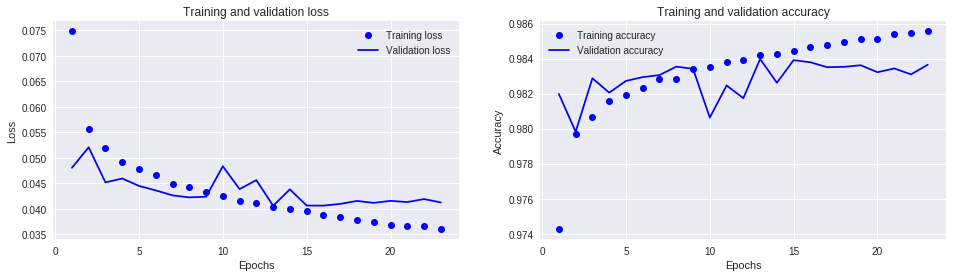

In [14]:
plot_history(history)

In [15]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 32s 988us/step
([0.039962146967794196, 0.9838529295090614], 0.9895828209833901)
